# TicketSleuth Experiments

In [1]:
options(repr.plot.width=10, repr.plot.height=5, jupyter.plot_mimetypes='image/svg+xml')
source('common.r')
out <- function(obj) write(obj, stdout())

In [10]:
source('common.r')
d <- data.ipa.tickets(where = "ipa_duration=60 and ipa_version = 'v3.1'")
out("data:   " + nrow(d))

d$grp <- d$bound
d$facet <- factor(d$honeycomb_mode)
d$x <- d$load

s <- subset(d, ipa_lease_period == '200ms')
out("subset: " + nrow(s))

The following `from` values were not present in `x`: world#512
The following `from` values were not present in `x`: consistency:strongwrite, tolerance:0, tolerance:0.01, tolerance:0.05, tolerance:0.1, latency:50ms, latency:10ms, consistency:weak


data:   125
subset: 125


In [19]:
unique(d$ipa_lease_period)

[1] "0ms"   "200ms"

In [23]:
sql("SELECT load, ipa_bound, ipa_lease_period as lease, honeycomb_mode as honeycomb, round(avg(read_lat_mean),2) as read_lat, round(avg(take_lat_mean),2) as take_lat, round(avg(res_consume_lat_mean), 2) as consume_lat, round(avg(res_cached_total/(res_cached_total+res_expired_total)),3) as cached, round(avg(res_forwards_total/res_decr_total),2) as forwards, take_count as takes, read_count as reads FROM s WHERE honeycomb = 'flat5' GROUP BY load, ipa_bound, honeycomb, lease ORDER BY honeycomb_mode")

,load,ipa_bound,lease,honeycomb,read_lat,take_lat,consume_lat,cached,forwards,takes,reads
1,128,consistency:strong,0ms,flat5,54.2,67.72,149.64,0,0,50527,75808
2,128,consistency:strong,200ms,flat5,14.74,37.55,228.36,0.587,0.01,79219,119279
3,128,consistency:weakwrite,0ms,flat5,56.35,70.45,149.4,0,0,48647,73390
4,128,consistency:weakwrite,200ms,flat5,15.65,38.65,226.98,0.59,0.01,78793,118380
5,512,consistency:strong,0ms,flat5,179.17,261.23,160.31,0,0,54787,81678
6,512,consistency:strong,200ms,flat5,14.66,40.79,228.03,0.593,0.01,80562,120307
7,512,consistency:weakwrite,0ms,flat5,257.09,271.7,154.4,0,0,52100,78515
8,512,consistency:weakwrite,200ms,flat5,16.07,34.09,227.95,0.592,0.01,79875,119666
9,2048,consistency:strong,0ms,flat5,489.95,464.23,195.93,0,0,67778,102255
10,2048,consistency:strong,200ms,flat5,14.52,42.46,223.07,0.606,0.01,78897,116915


Warning message:
: Removed 7 rows containing missing values (geom_errorbar).

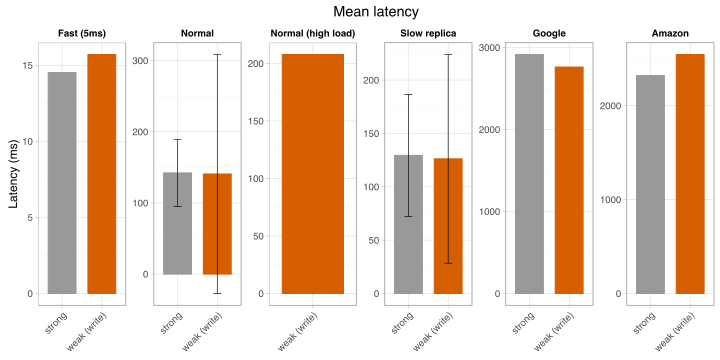

In [18]:
source('common.r')

ggplot(subset(s, !is.na(condition) & ipa_lease_period == '200ms'), aes(
    y = read_lat_mean,
    x=grp, color=grp, fill=grp, group=grp
))+
    #stat_summary(geom='bar', fun.y=mean, size=0.5, width=0.7)+
    geom_meanbar()+
    ggtitle('Mean latency')+
    xlab('load (concurrent requests)')+
    ylab('Latency (ms)')+
    facet_wrap(~condition, ncol=6, scale="free")+
    theme_mine()+
    theme.bar()+
    ipa.scales()

Warning message:
In simpleLoess(y, x, w, span, degree = degree, parametric = parametric, : pseudoinverse used at 6.975Warning message:
In simpleLoess(y, x, w, span, degree = degree, parametric = parametric, : neighborhood radius 4.025Warning message:
In simpleLoess(y, x, w, span, degree = degree, parametric = parametric, : reciprocal condition number  1.7336e-17Warning message:
In simpleLoess(y, x, w, span, degree = degree, parametric = parametric, : There are other near singularities as well. 9.1506Warning message:
In predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), : pseudoinverse used at 6.975Warning message:
In predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), : neighborhood radius 4.025Warning message:
In predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x e

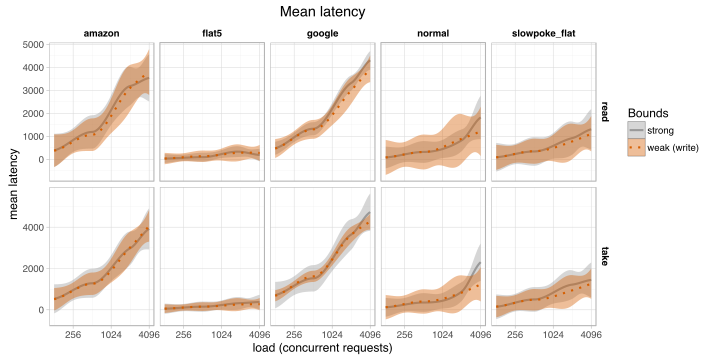

In [17]:
source('common.r')
ggplot(melt.by(s, 'optype', '(take|read)_lat_mean'), aes(
    x=x, y=value, color=grp, fill=grp, linetype=grp, group=grp
))+
    #stat_summary(geom='line', fun.y=mean, size=0.6)+
    stat_smooth()+
    ggtitle('Mean latency')+
    xlab('load (concurrent requests)')+
    ylab('mean latency')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(optype~honeycomb_mode, scales="free")+
    theme_mine()+
    ipa.scales()

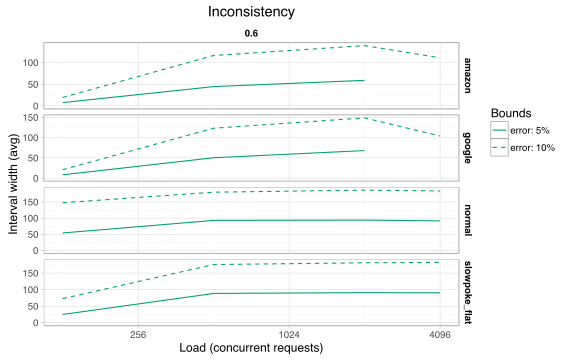

In [127]:
ggplot(subset(s, grepl('tolerance:',ipa_bound)), aes(
    x = x, y= histograms_interval_width_mean, color=grp, fill=grp, group=grp, linetype=grp
))+
    stat_summary(geom='line', fun.y=mean)+
    ggtitle('Inconsistency')+
    xlab('Load (concurrent requests)')+ 
    ylab('Interval width (avg)')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~ipa_zipf, scales="free")+
    ipa.scales()+
    theme_mine()

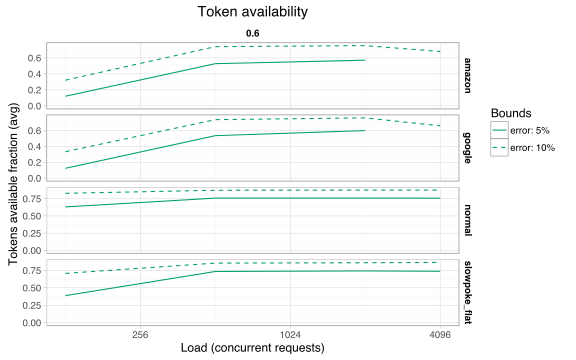

In [128]:
ggplot(subset(s, grepl('tolerance:',ipa_bound)), aes(
    x = x, y = fraction_immediate, color=grp, fill=grp, group=grp, linetype=grp
))+
    stat_summary(geom='line', fun.y=mean)+
    ggtitle('Token availability')+
    xlab('Load (concurrent requests)')+
    ylab('Tokens available fraction (avg)')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~ipa_zipf, scales="free")+
    ipa.scales()+
    theme_mine()

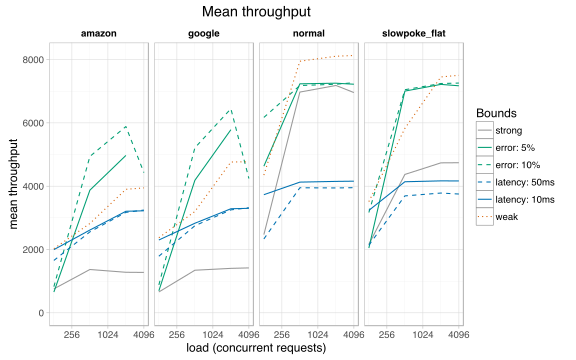

In [129]:
ggplot(subset(s, x <= 4096), aes(
    x=x, y=overall_rate_mean, color=grp, fill=grp, group=grp, linetype=grp
))+
    stat_summary(geom='line', fun.y=mean)+
    ggtitle('Mean throughput')+
    xlab('load (concurrent requests)')+
    ylab('mean throughput')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(~honeycomb_mode, scales="free")+
    ipa.scales()+
    theme_mine()

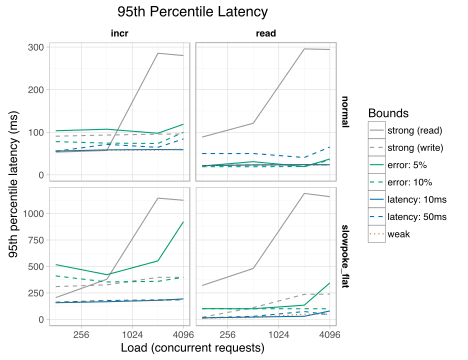

In [28]:
p = "95"
ggplot(melt.by(s, 'op', 'timers_(read|incr)_latency_p'+p+'$'), aes(
    x=x, y=value, color=grp, fill=grp, group=grp, linetype=grp
))+
    stat_summary(geom='line', fun.y=mean)+
    ggtitle(p+'th Percentile Latency')+
    xlab('Load (concurrent requests)')+
    ylab(p+'th percentile latency (ms)')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~op, scale="free")+
    ipa.scales()+
    theme_mine()

In [66]:
r <- data.ipa.rawmix(where="datatype='counter' and ipa_duration=60 and ipa_version = 'v1.9' and ipa_bound LIKE 'tolerance%'")

The following `from` values were not present in `x`: world#128
The following `from` values were not present in `x`: consistency:strong, consistency:strongwrite, latency:50ms, latency:10ms, consistency:weak


In [67]:
sql("SELECT load, ipa_bound, honeycomb_mode, timers_read_latency_mean as mean_lat, round(res_immediates_total/res_incrs_total,4) as immed, round(res_refreshes_total/res_incrs_total,4) as refresh, round(res_out_of_bounds_total/res_incrs_total,4) as out_of_bounds, res_incrs_total as incrs FROM r WHERE ipa_bound LIKE '%tolerance%' ORDER BY honeycomb_mode")

,load,ipa_bound,honeycomb_mode,mean_lat,immed,refresh,out_of_bounds,incrs
1,128,tolerance:0.1,normal,10.90409,0.8386,0.1176,0.0438,76415
2,128,tolerance:0.05,normal,12.18976,0.6965,0.1765,0.127,72226
3,512,tolerance:0.1,normal,11.03484,0.8697,0.1085,0.0218,88337
4,512,tolerance:0.05,normal,10.8847,0.7507,0.1667,0.0826,87293
5,2048,tolerance:0.1,normal,11.01613,0.8684,0.1094,0.0222,86780
6,2048,tolerance:0.05,normal,10.69321,0.7458,0.1675,0.0868,86073
7,4096,tolerance:0.05,normal,11.13091,0.7507,0.1657,0.0837,87104
8,128,tolerance:0.1,normal,10.763,0.84,0.1184,0.0416,75474
9,128,tolerance:0.05,normal,10.76421,0.7082,0.174,0.1178,75021
10,512,tolerance:0.1,normal,11.09122,0.8688,0.1102,0.021,85528


# Retwis

In [ ]:
d <- data.or.csv(
    csv = 'data/owl.csv',
    gen = function() data.owl()
)

In [ ]:
subset(d, duration == 60 & blockade == 'slow', select=c('c_reqs','ipa_consistency','op_rate'))

In [ ]:
d$x <- d$c_reqs
d$grp <- d$ipa_consistency
s <- subset(d, duration == 60 & blockade == 'slow' & !is.na(ipa_consistency))

ggplot(s, aes(x=x, y=op_rate, color=grp, fill=grp, group=grp))+
    stat_summary(geom='line', fun.y=mean)+
    xlab('system load (# concurrent requests)')+
    ylab('mean cassandra op latency (ms)')+
    my_theme()

In [ ]:
ggplot(s, aes(x=x, y=op_lat_mean, color=grp, fill=grp, group=grp))+
    stat_summary(geom='line', fun.y=mean)+
    xlab('system load (# concurrent requests)')+
    ylab('mean cassandra op latency (ms)')+
    my_theme()